# OJS Growth

In [1]:
# knitr options
knitr::opts_chunk$set(echo = FALSE, message = FALSE, warning = FALSE)

In [ ]:
# Libraries
pacman::p_load(tidyverse, countrycode, sf, state, htmltools, htmlwidgets, urltools, janitor, DT, RColorBrewer, plotly, readxl)
tld <- read_csv(here::here("data/tld-country.csv"))
tld_from_ip <- read_csv(here::here("data/tld_from_ip.csv"))

# Global

In [ ]:
# Data (Aug 5, 2021)
df <- read_csv(here::here("data/jonas/report-latest.csv"))

canada.states <- 
  c("Alberta", "British Columbia", "Labrador", "Manitoba", "New Brunswick", "Newfoundland", "Nova Scotia", "Nunavut", "North West Terr.", "Ontario", "Prince Edward Is.", "Québec (Province)", "Saskatchewan", "Yukon")

# correcting some oai urls
df <- 
  df %>% 
  mutate(oai_url = if_else(str_detect(oai_url, "^//"), str_c("http:", oai_url), oai_url))


# getting domain and tld
df <-  
  bind_cols(
    df,
    df %>% pull(oai_url) %>% domain() %>% tld_extract()
  ) %>% 
  mutate(country_consolidated = str_to_lower(country_consolidated) %>% str_trim()) %>% 
  left_join(tld, by = c("country_consolidated" = "tld"))

# Cleaning countries + Mapping countries to continents
df <-
  df %>% 
  mutate(
    country = country_clean,
    ojs_v2 = str_detect(version, "^2"),
    ojs_v3 = str_detect(version, "^3"),
    version_clean = case_when(
      ojs_v2 ~ "Version 2",
      ojs_v3 ~ "Version 3",
      TRUE ~ "Other"
    )
  ) %>% 
  mutate(
    country = if_else(country == "Washington (State)", "United States", country),
    country = if_else(str_detect(country, "United States|New York|District of Columbia"), "United States", country),
    country = if_else(country %in% state.name, "United States", country),
    country = if_else(country %in% canada.states, "Canada", country),
    country = if_else(str_detect(country, "China"), "China", country),
    country = if_else(str_detect(country, "Armenia"), "Armenia", country),
    country = if_else(str_detect(country, "Georgia"), "Georgia", country),
    country = if_else(str_detect(country, "Australia|New South Wales|Queensland|Victoria"), "Australia", country),
    country = if_else(str_detect(country, "England|British"), "United Kingdom", country),
    country = if_else(str_detect(country, "Russia|Soviet Union"), "Russia", country),
    country = if_else(str_detect(country, "Palestine"), "Palestine", country),
    country = if_else(country == "Korea (South)", "South Korea", country)
  ) %>% 
  select(-country_clean)

continents <-
  df %>%
  pull(country) %>% 
  countrycode(origin = "country.name", destination = "continent")

df <- df %>% bind_cols(continents)

# rename last column to `continent`
names(df)[length(names(df))] <- "continent"

df <-
  df %>% 
  filter(total_record_count > 0) %>%
  distinct(oai_url, repository_name, set_spec, .keep_all = T) %>% 
  select(-c(record_count_1300:record_count_1899))

df %>% glimpse()

<br/>

## Active journals (5 or more records published per year)

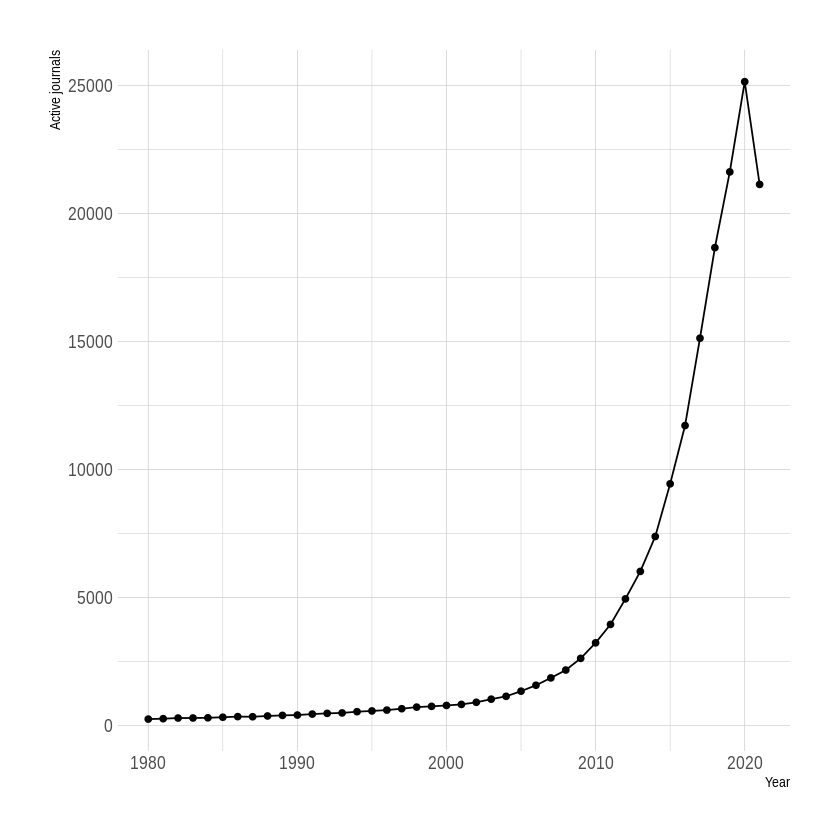

In [4]:
df %>%
  drop_na(country) %>% 
  select(context_name, record_count_1980:record_count_2021) %>% 
  pivot_longer(cols = starts_with("record_count")) %>% 
  mutate(
    name = parse_number(name)
  ) %>% 
  filter(value >= 5) %>% 
  count(name) %>% 
  ggplot(aes(name, n)) +
  geom_point() +
  geom_line() +
  hrbrthemes::theme_ipsum() +
  labs(
    x = "Year",
    y = "Active journals"
  )

<br/>

## Articles published

In [5]:
total_records <-
  df %>%
  drop_na(country) %>% 
  select(record_count_1980:record_count_2021) %>% 
  pivot_longer(cols = starts_with("record_count")) %>% 
  mutate(
    name = parse_number(name)
  ) %>% 
  group_by(name) %>% 
  summarize(value = sum(value, na.rm = T)) %>% 
  summarize_all(sum) %>% 
  pull(value)

In [6]:
print("Total records published till date:")
total_records

[1] "Total records published till date:"


[1] 6685277

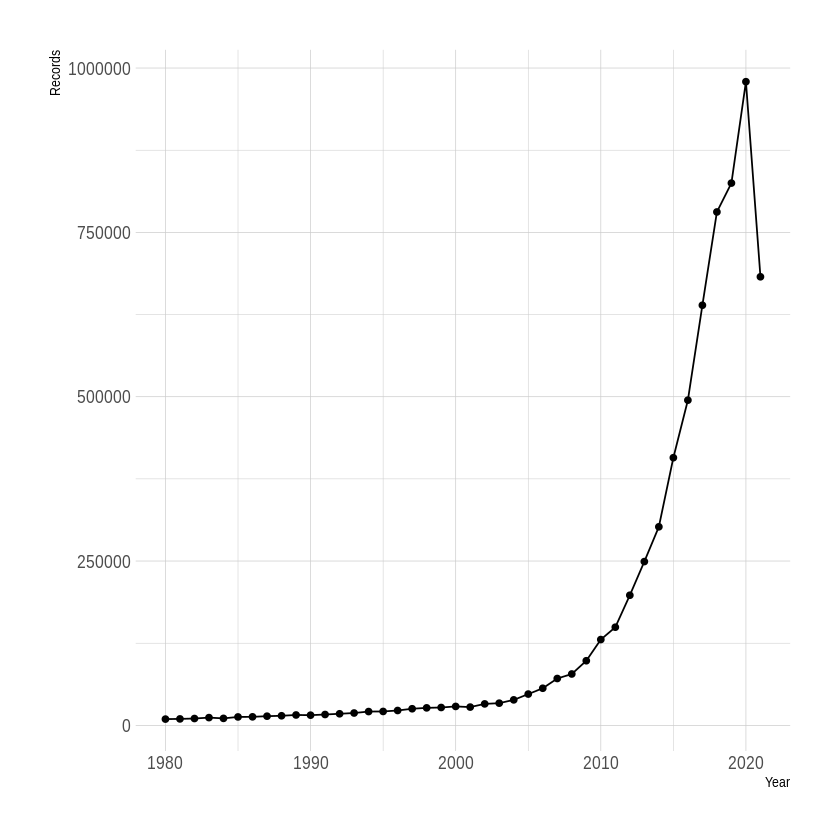

In [7]:
df %>%
  drop_na(country) %>% 
  select(record_count_1980:record_count_2021) %>% 
  pivot_longer(cols = starts_with("record_count")) %>% 
  mutate(
    name = parse_number(name)
  ) %>% 
  group_by(name) %>% 
  summarize(value = sum(value, na.rm = T)) %>%
  ggplot(aes(name, value)) +
  geom_point() +
  geom_line() +
  hrbrthemes::theme_ipsum() +
  labs(
    x = "Year",
    y = "Records"
  )

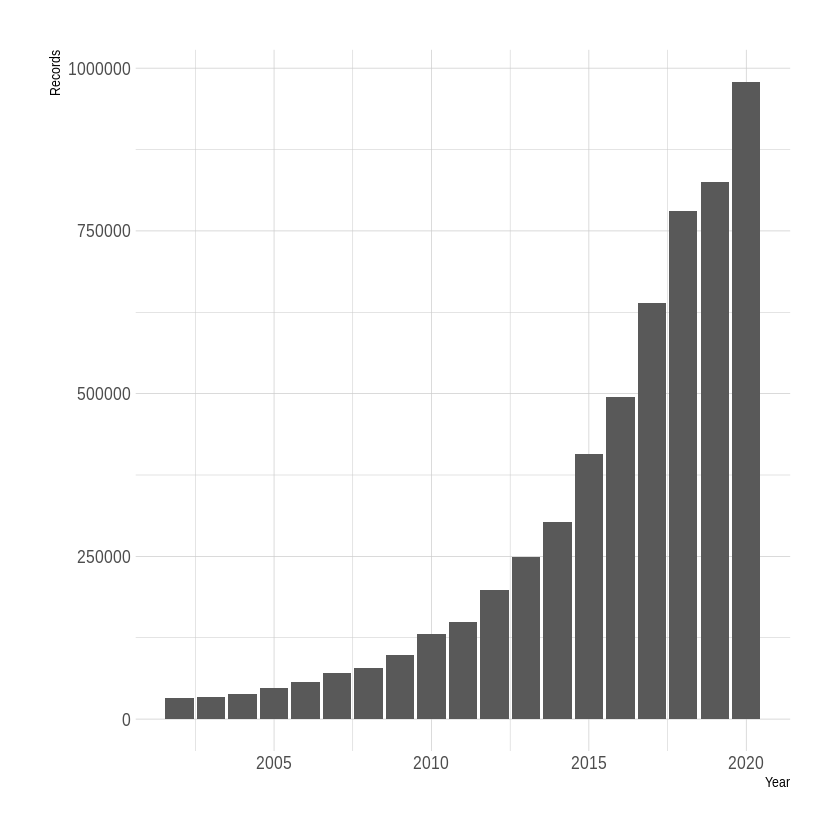

In [8]:
df %>%
  drop_na(country) %>% 
  select(record_count_2002:record_count_2020) %>% 
  pivot_longer(cols = starts_with("record_count")) %>% 
  mutate(
    name = parse_number(name)
  ) %>% 
  group_by(name) %>% 
  summarize(value = sum(value, na.rm = T)) %>%
  ggplot(aes(name, value)) +
  geom_col() +
  hrbrthemes::theme_ipsum() +
  labs(
    x = "Year",
    y = "Records"
  )

## Average articles per journal

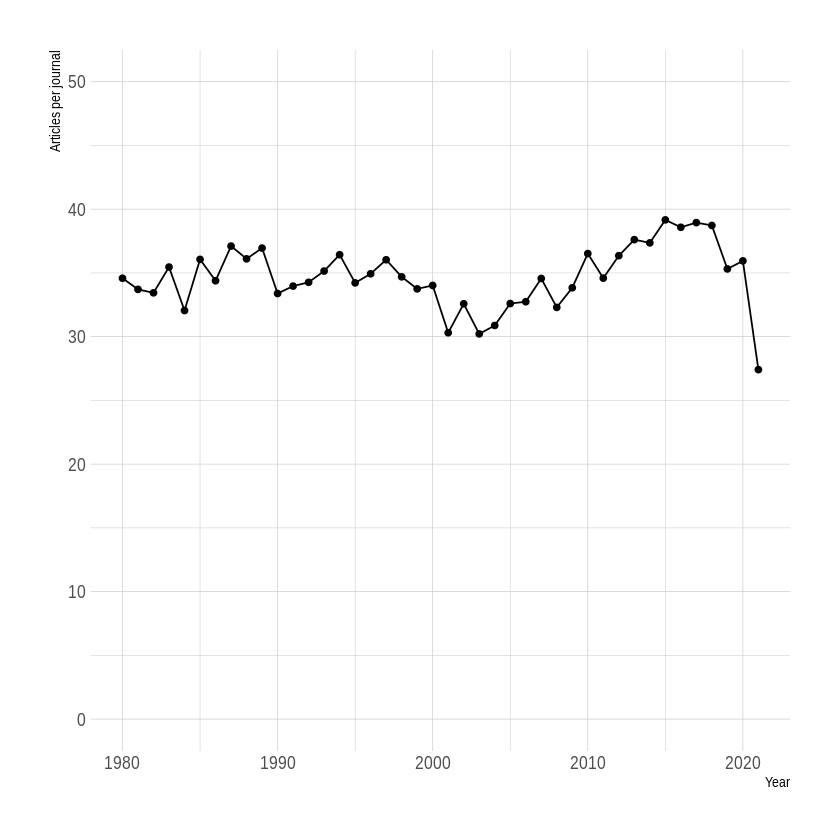

In [9]:
df %>%
  drop_na(country) %>% 
  select(record_count_1980:record_count_2021) %>% 
  pivot_longer(cols = starts_with("record_count")) %>% 
  mutate(
    name = parse_number(name)
  ) %>% 
  filter(value > 0) %>%
  group_by(name) %>% 
  summarize(
    journals = n(),
    records = sum(value, na.rm = T)
  ) %>% 
  mutate(
    articles_per_journal = records/journals
  ) %>% 
  ggplot(aes(name, articles_per_journal)) +
#  geom_col(alpha = 0.9) +
  geom_line() +
  geom_point() +
  hrbrthemes::theme_ipsum() +
  scale_y_continuous(limits = c(0, 50), breaks = seq(0, 50, 10)) +
  labs(
    x = "Year",
    y = "Articles per journal"
  )